In [4]:
#from BLEanalysis.pathinference import Path
#from BLEanalysis.kernels import EQIntegralKernel, ExponentiatedQuadraticKernel
from BLEanalysis.synthetic import SimpleDemo
#import numpy as np

In [5]:
#import tensorflow as tf
#import tensorflow_probability as tfp
#from tensorflow_probability import distributions as tfd
#import numpy as np


# TODO Work our which of these imports are necessary for this file


class Kernel:
    def __init__(self):
        """Base kernel class"""
        raise NotImplementedError
        
    def K(self, X, Xprime):
        raise NotImplementedError
        
class ExponentiatedQuadraticKernel(Kernel):
    def __init__(self, lengthscale, scalefactor):
        """Computes the EQ kernel, with the second column a dimension index.
        
        the covariance method returns: scalefactor^2 * exp((-(x-x')^2) / (2*ls^2))
        if in same dimension; otherwise returns zero.
        
        Parameters:
         lengthscale: lengthscale of the kernel
         scalefactor: the premultiplier.

        """
        self.lengthscale = lengthscale
        self.scalefactor = scalefactor
        
    def K(self, X, Xprime):
        """EQ kernel: scale^2 * exp((-(x-x')^2) / (2*ls^2))
        
        Parameters:
        X and Xprime:
        
        Returns the covariacne between points in X and Xprime.
        
        TODO Computing more than we need (as 2/3rds gets set to zero.
        """
        covariance = (k.scalefactor ** 2) * np.exp(-(X[:,0:1]-Xprime[:,0:1].T)**2 / (2*k.lengthscale**2))
        axsel = X[:,1:2]==Xprime[:,1:2].T
        covariance *= axsel
        return covariance

In [54]:
path.y_pos

array([-0.36716653, -0.98273958, -0.33443845, -0.98194843, -0.28945959,
       -0.99165562, -0.12653192, -0.9986358 , -0.09889175, -0.99913634,
        0.11864139, -0.98408287,  0.27633088, -0.92870829,  0.56351524,
       -0.87568278,  0.71288823, -0.78531811,  0.93723717, -0.64245126,
        0.98979271, -0.52762552,  0.99900385, -0.40442693,  0.99189424,
       -0.19222343,  0.96724813, -0.12415319,  0.95787931, -0.05255883,
       -0.93015522, -0.18499436, -0.9424176 , -0.18914883, -0.95719023,
       -0.12891523, -0.99196254, -0.05221625, -0.9950982 ,  0.04155198,
       -0.99293717,  0.17771016, -0.96106256,  0.37081115, -0.82610567,
        0.4828868 , -0.70127767,  0.61909245, -0.34869254,  0.76632655,
       -0.14251453,  0.84947708, -0.04462409,  0.91457031,  0.12706619,
        0.98135119,  0.25383275,  0.99226306,  0.28717106,  0.99861783])

In [159]:
#from autograd.scipy.stats import multivariate_normal as mvn

#from autograd.misc.optimizers import adam
#from autograd.numpy.random import multivariate_normal as mvn
#import autograd.numpy as np

from jax.scipy.stats import norm
from jax.random import multivariate_normal as mvn
from jax.random import normal
from jax import random
key = random.key(0)
import jax.numpy as np
#from scipy.stats import norm
#from autograd import grad

def kl_mvn(m0, S0, m1, S1):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    

    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )

    copied from https://stackoverflow.com/a/55688087
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

class Path:
    def __init__(self, observation_times, observations, kernel, noise_scale, inducing_points):
        """
        Performs variational inference using the 'single angle only' observations to work out possible paths of the tag.
        
        This uses observations that consist of single angles, rather than probability distributions of angles.
        
        Parameters:
         observation_times : an array of the times the observations were made.
         observations : array of the angles they were (radians)
         kernel : an instantiation of a kernel class
         noise_scale : the standard deviation (TODO or variance?? TBC) of the Gasussian noise model
         inducing_points : either the number of inducing points, or an array of their values.
                  If the former, the class places inducing points, with some before and after the data.
        """
        self.observations = observations # Angle observations made
        self.observation_times = observation_times # Times observations were made at
        self.noise_scale = noise_scale # Noise scale of likelihood
        self.kernel = kernel # Kernel function
        self.jitter = 0.01 # Jitter applied to covariance matrix during training

        if type(inducing_points)==int:
            self.Z = self.selectPoints(inducing_points) # Select inducing points
        else:
            self.Z = inducing_points
        self.loss_history = []

    def selectPoints(self, number, margin = 3):
        """Returns an array of one-dimensional (inducing) point locations, placed evenly over the domain of times
        in self.observation_times, with a margin added.

        TODO: Could make the margin depend on kernel lengthscale
        """
        
        max_time = np.max(self.observation_times) + margin
        min_time = np.min(self.observation_times) - margin       
        result = []        
        for vector_observed in range(int(self.observations.shape[1] / 2)):        
            result.extend(np.c_[np.linspace(min_time, max_time, number), np.full(number, vector_observed)])
        return np.array(result)

        
    def run(self,iterations=500,learning_rate = 0.15, number_samples = 100):
        self.ndims = 2
        self.number_samples = number_samples
        self.nind = self.Z.shape[0]
        self.diag_jitter = np.eye(self.nind) * self.jitter
        #Precompute various matrices
        self.X = np.c_[np.tile(self.observation_times, self.ndims), np.repeat(np.arange(self.ndims),len(self.observation_times))]
        self.y = self.observations
        self.n = len(self.y)
        # GP(Kzx Kzz^-1 y, Kzz - Kzx Kxx^-1 Kxz)
        self.Kzz = self.kernel.K(self.Z, self.Z) + np.eye(self.nind) * self.jitter
        self.Kxx = self.kernel.K(self.X, self.X) + np.eye(self.X.shape[0]) * self.jitter
        self.Kxz = self.kernel.K(self.X, self.Z)
        self.Kzx = self.Kxz.T
        self.KzzinvKzx = np.linalg.solve(self.Kzz, self.Kzx)
        self.KxzKzzinv = self.KzzinvKzx.T
        self.KxzKzzinvKzx = self.Kxz @ self.KzzinvKzx
        
        self.prior_mean = np.zeros(self.nind)
        self.prior_covariance = self.kernel.K(self.Z, self.Z)
        
        ###self.surrogate_mean = normal(key,self.nind)
        
        #cholesky decomposition cov = LL^T
        ###self.surrogate_cov_tril = np.tril(0.1*normal(key,(self.nind,self.nind))) #where L is a lower triangular matrix with real and positive diagonal entries
        self.y_vects = np.c_[self.y[:,2:],np.zeros(self.n)] #vectors to bee extracted from 'y'
        self.y_pos = self.y[:,:2].T.reshape(60)
        #self.calc_elbo(surrogate_mean,surrogate_cov_tril)
        #return grad(self.calc_elbo)

    def get_posterior_distribution_parameters(self,surrogate_mean,surrogate_cov_tril):
        tril = np.tril(surrogate_cov_tril)
        surrogate_cov = tril@tril.T + self.diag_jitter
        posterior_mean = (self.KxzKzzinv @ surrogate_mean)
        posterior_cov = self.Kxx - self.KxzKzzinvKzx + self.KxzKzzinv @ surrogate_cov @ self.KzzinvKzx        
        return posterior_mean, posterior_cov, surrogate_cov
        
    def calc_elbo(self,surrogate_mean,surrogate_cov_tril):
        posterior_mean, posterior_cov, surrogate_cov = self.get_posterior_distribution_parameters(surrogate_mean,surrogate_cov_tril)
        samples = mvn(key,posterior_mean,posterior_cov,self.number_samples) - self.y_pos #number_samples x number_obserations
        samples_with_z = np.c_[samples,np.zeros([self.number_samples,self.n])] #adds an extra axis
        s = samples_with_z.reshape(self.number_samples,3,self.n)
        s = np.swapaxes(s,1,2)        
        cross_vects = np.cross(self.y_vects,s)
        distances = np.linalg.norm(cross_vects,axis=2) #don't need to divide by np.linalg.norm(y[:,2:],axis=1), as this is set to one
        elbo = -(np.mean(np.sum(norm.logpdf(distances,0,0.1),axis=1))- kl_mvn(self.prior_mean, self.prior_covariance, surrogate_mean, surrogate_cov))
        return elbo
        
        
demo = SimpleDemo()
k = ExponentiatedQuadraticKernel(7.0,5.0)
demo.observations = demo.observations[:,:]
demo.obstimes = demo.obstimes[:]

#posterior_mean = (path.KxzKzzinv @ path.surrogate_mean)
import matplotlib.pyplot as plt

path = Path(demo.obstimes,demo.observations,k,1.0,8)
path.run()
#path.surrogate_mean = np.array([10.0,30,50,70,0,20,40,60])
#path.surrogate_cov_tril = np.eye(8,8)*6
#print(path.calc_elbo(path.surrogate_mean,path.surrogate_cov_tril))

In [160]:
from jax import grad
import optax
optimizer = optax.adam(5.0)
## Obtain the `opt_state` that contains statistics for the optimizer.
#params = {'w': jnp.ones((num_weights,))}

surrogate_mean = normal(key,path.nind)*20
surrogate_cov_tril = np.eye(path.nind) #np.tril(0.05*normal(key,(path.nind,path.nind)))

opt_state = optimizer.init((surrogate_mean,surrogate_cov_tril))

for it in range(100):
    grads = grad(path.calc_elbo,[0,1])(surrogate_mean,surrogate_cov_tril)
    updates, opt_state = optimizer.update(grads, opt_state)
    surrogate_mean,_ = optax.apply_updates((surrogate_mean,surrogate_cov_tril), updates)
    if it%50==0: 
        print(path.calc_elbo(surrogate_mean,surrogate_cov_tril))
        print(surrogate_mean)

optimizer = optax.adam(0.3)
opt_state = optimizer.init((surrogate_mean,surrogate_cov_tril))

for it in range(100):
    grads = grad(path.calc_elbo,[0,1])(surrogate_mean,surrogate_cov_tril)
    updates, opt_state = optimizer.update(grads, opt_state)
    surrogate_mean,surrogate_cov_tril = optax.apply_updates((surrogate_mean,surrogate_cov_tril), updates)
    if it%50==0: 
        print(path.calc_elbo(surrogate_mean,surrogate_cov_tril))
        print(surrogate_mean)

2002399.1
[  6.7   33.2   10.91  27.42  11.69 -11.52  17.96  15.87 -10.65 -14.08
  17.6   21.3   -1.56 -17.47 -28.21   0.46]
23017.328
[ 40.41   5.8   11.43  46.6   41.27  30.14  77.51 -14.44  48.33 -22.4
  13.64  34.15  24.34  26.28  51.04 -31.33]
9571.854
[  6.06   7.98  12.69  44.12  41.72  33.9   80.15  -6.12  24.36  -6.55
  15.38  30.44  24.17  31.2   63.61 -22.48]
5133.4355
[ -6.68   2.98  14.13  44.54  40.45  33.08  88.44   5.59  11.44 -10.16
  15.42  30.43  23.8   31.54  69.31 -11.01]


(Array([14.49,  4.78], dtype=float32),
 Array([[0.87, 0.39],
        [0.39, 0.57]], dtype=float32))

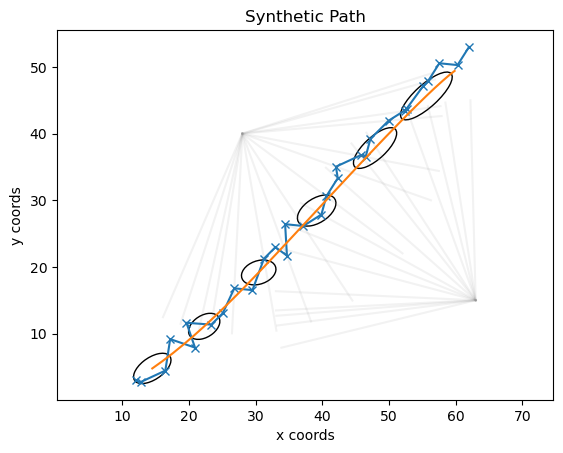

In [162]:
from BLEanalysis import confidence_ellipse

demo.plot()
posterior_mean, posterior_cov, _ = path.get_posterior_distribution_parameters(surrogate_mean,surrogate_cov_tril)
plt.plot(posterior_mean[:len(posterior_mean)//2],posterior_mean[len(posterior_mean)//2:],'-')

ax = plt.gca()
for i in range(0,len(path.y),5):
    el = confidence_ellipse(posterior_mean[i::len(posterior_mean)//2],posterior_cov[i::len(posterior_mean)//2,i::len(posterior_mean)//2],ax)
    ax.add_patch(el)
posterior_mean[0::len(posterior_mean)//2],posterior_cov[0::len(posterior_mean)//2,0::len(posterior_mean)//2]